In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import model.train_schedule
import model.model_defination
import torch
from scipy.interpolate import griddata
import os
from typing import Union


In [2]:
# img = Image.open(path).convert('L')
# img = np.array(img, dtype=np.float32)
# print('图片大小：', img.shape)
# print(img)
# img = np.expand_dims(img, 0)

def loadSingleImg(path:str) -> np.ndarray:
    """
    载入单张图片，形状为NCHW
    """
    img = Image.open(path).convert('L')
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, 0)
    img = np.expand_dims(img, 0)
    # img = torch.from_numpy(img)
    return img

def loadImages(path_to_folder:str) -> np.ndarray:
    """
    载入给定文件夹中的所有图片，形状为NCHW

    返回np.ndarray
    """
    pics = os.listdir(path_to_folder)
    # 首先载入第一张图片
    imgs = loadSingleImg(os.path.join(path_to_folder, pics[0]))
    for i in range(1,len(pics)):
        img = loadSingleImg(os.path.join(path_to_folder, pics[i]))
        imgs = np.concatenate((imgs,img),axis=0)
    return imgs

##### 预处理步骤
首先，0.5级的LASCO C2数据文件会处理为1级数据。所有的(1024,1024)分辨率大小的图片会被下采样至(512,512)。然后，会经过噪声滤波以压制部分尖锐噪声。文中使用3*3正则化正方滤波器.该滤波器是基本的线性滤波器，计算邻近像素的平均值，然后再生成差分图。
##### 图像分类
所有的(1024,1024)差分图会被下采样(112,112)大小，作为神经网络的输入。经过卷积层1，输出为(20,108,108)，经过池化层1，输出为(20,54,54)，经过卷积层2，输出为(50,50,50)，经过池化层2，输出为(50,25,25).然后经过两全连接层，得到最终的输出。

In [3]:
def ho(h, f, padding, stride):
    return (h - f + 2 * padding) / stride + 1


In [4]:
# 原文中:input N*112*112
print('原文中：')
print(ho(112, 5, 0, 1)) # 卷积后N*108*108
print(ho(108, 2, 0, 2)) # 池化后N*54*54
print(ho(54, 5, 0, 1)) # 卷积后N*50*50
print(ho(50, 2, 0, 2)) # 池化后N*25*25

#我的工作中采用input为 N*224*224
print('我的工作：')
print(ho(224, 5, 0, 1))  # 卷积后N*220*220
print(ho(220, 2, 0, 2))  # 池化后N*110*110
print(ho(110, 5, 0, 1))  # 卷积后N*106*106
print(ho(106, 2, 0, 2))  # 池化后N*53*53


原文中：
108.0
54.0
50.0
25.0
我的工作：
220.0
110.0
106.0
53.0


##### CME探测
首先利用register_forward_hook函数得到卷积层输出的activation

In [5]:
# net = model.model_defination.LeNet5()
# img_path = r'D:\Programming\CME_data\CME\Halo\20130830_032405_lasc2rdf_aia193rdf.png'
# parameter_path = r'D:\Programming\codetest\CMEclassfication\log\2022_04_13_20_00_25\parameters.pkl'
# map_location = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# net.load_state_dict(torch.load(parameter_path,map_location=map_location))

def getActivation(net: torch.nn.Module, x:Union[torch.Tensor,np.ndarray]) -> np.ndarray:
    """ 
    获得最后一层卷积层的输出
    
    输出结果的维度为N*h*w*d
    """
    if isinstance(x,np.ndarray):
        x = torch.from_numpy(x)
    net.eval()
    activation = []

    def forward_hook(modeul, data_input, data_output):
        activation.append(data_output.detach().permute(0, 2, 3, 1).numpy())

    net.conv2.register_forward_hook(forward_hook)
    out = net(x)
    return activation[0]


# img = loadSingleImg(img_path)
# activat = getActivation(net, img)
# out = net(torch.from_numpy(img))
# print('act:', activat.shape)
# print('out:', torch.argmax(out, dim=1))


##### CME Co-localiaztion
从卷积层的输出特征图中提取信息。利用DDT手段进行图像共定位(Co-locolization)。共定位就是在一系列的图像中找到相关物体的位置。对于一张H*W大小的图片，其activation(卷积层的输出)就是一个形状为h*w*d的三维张量。该张量可被认为有h*w个cell，每个cell包含一个d维的DD(deep desciptor)向量。  
首先，有N张图片构成的序列，这N个图片包含着同一类别的目标。这N张图片生成N个activation，每一个activation都是k*w*d维的张量。计算这N个activation的平均张量，然后获得协方差矩阵。

In [6]:
def getMeanVector(x: np.ndarray):
    """
    获得所有descriptor的平均向量
    
    x为N*h*w*d维的np.array
    """
    return np.mean(x, axis=(0, 1, 2))


def cov(x: np.ndarray):
    """
    获得协方差矩阵
    
    x为N*h*w*d维的np.ndarray
    """
    k = x.shape[0] * x.shape[1] * x.shape[2]
    xMeanVector = getMeanVector(x)
    convMat = np.zeros(x.shape[3])
    for n in range(x.shape[0]):
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                deviaVector = x[n][i][j] - xMeanVector
                # 对x中取出的descripter向量进行升维
                # 因为直接取出的descripter向量是一维的，直接相乘会出现问题，需转化为列向量
                deviaVector = np.expand_dims(deviaVector, axis=1)
                tempMat = np.matmul(deviaVector, deviaVector.T)
                convMat = convMat + tempMat
    return convMat / k


求最大特征值所对应的特征向量以及指示矩阵。  
原特征图的形状为(h,w,d)，可认为原特征图的每一个像素都构成了一个观测样本，d维的descripter向量就是该观测样本的值，再利用PCA的方法，求出该协方差矩阵的特征值和特征向量，并投影到最大特征值对应的特征向量方向上。

In [7]:
def getPrinCompVector(activation: np.ndarray) -> np.ndarray:
    """
    获得主成分向量
    
    activation的形状为N*h*w*d，是卷积层输出的特征图
    """
    covMatrix = cov(activation)
    eigValue, eigVector = np.linalg.eig(covMatrix)
    prinCompInd = np.argmax(eigValue)
    prinCompVector = eigVector[:, prinCompInd]
    # prinComp形状为(50,)，对其增加一维变为列向量
    prinCompVector = np.expand_dims(prinCompVector, axis=1)
    return prinCompVector


def getIndicatorMatrix(activation: np.ndarray, ind: int,
                       prinCompVector: np.ndarray) -> np.ndarray:
    """获得索引为ind的图片的activation所对应的Indicator Matrix

    Parameters
    ----------
    activation : np.ndarray
        维度为N*h*w*d,是N张图片的激活层构成的数组
    ind : int
        表示需求出指示矩阵的图片对应的索引
    prinCompVector : np.ndarray
        最大特征值对应的主成分向量

    Returns
    -------
    np.ndarray 
        指示矩阵
    """
    img = activation[ind]
    xMeanVector = getMeanVector(activation)
    indicatorMatrix = np.zeros((activation.shape[1], activation.shape[2]))
    for i in range(activation.shape[1]):
        for j in range(activation.shape[2]):
            indicatorMatrix[i, j] = np.matmul(prinCompVector.T,
                                              img[i, j] - xMeanVector)
    return indicatorMatrix


# prinCompVector = getPrinCompVector(activat)
# indicatorMat = getIndicatorMatrix(activat,0, prinCompVector)
# print(np.where(indicatorMat > 0, 1, 0))
# print(indicatorMat)


指示矩阵的正值反映了d维descriptor的相关性大小。其值越大表明相关性越大。主成分向量是由N张图片获得的，因此正的相关性就反映了N张图片的共同特征。因此可以用0值作为阈值，大于0表示共同的物体，小于0表示背景或者不经常出现的物体。
将指示矩阵利用最近邻插值，变为原图片的大小。

In [8]:
def reSize(x: np.ndarray, targetSize=(512, 512)) -> np.ndarray:
    """利用最近邻插值，更改矩阵大小

    Parameters
    ----------
    x : np.ndarray
        需要变换的矩阵
    targetSize : tuple, optional
        目标大小, by default (512, 512)

    Returns
    -------
    np.ndarray
        修改大小后的矩阵
    """
    pointXCoord = np.floor(np.linspace(0, targetSize[0] - 1, x.shape[0]))
    pointYCoord = np.floor(np.linspace(0, targetSize[1] - 1, x.shape[1]))
    pointCoord = np.array([(i, j) for i in pointXCoord for j in pointYCoord])
    X = np.arange(0, targetSize[0])
    Y = np.arange(0, targetSize[1])
    X, Y = np.meshgrid(X, Y)
    reSizedX = griddata(pointCoord, x.flatten(), (X, Y), method='nearest')
    # 此处返回的数组应为插值后的数组的转置，原因在于meshgrid生成的X,Y数组的顺序不同
    reSizedX = reSizedX.T
    return reSizedX


# reSizedIndicator = reSize(indicatorMat)
# reSizedIndicator.shape

将大小改变后的指示矩阵二值化，大于0的值修改为1，小于0的值修改为0.然后利用flood-fill算法找到正值区域的最大连通分量

In [9]:
def getNextStartPoint(mask):
    '''查找下一个未被标记的点的坐标，若有这样的点则返回一个这样的点的坐标，若无则返回None'''
    ind = np.argwhere(mask == 0)
    if ind.size > 0:
        return tuple(ind[0])
    else:
        return None


def isInside(point:tuple, xBound:tuple, yBound:tuple) -> bool:
    '''
    判断点point是否在界限内
    
    xBound和yBound均为二元组，分别为x和y坐标的上下界。
    '''
    if xBound[0] <= point[0] <= xBound[1] and yBound[0] <= point[1] <= yBound[
            1]:
        return True
    else:
        return False


def getConnectedComponet(reSizedIndicator:np.ndarray) -> tuple:
    """找到指示矩阵中的最大连通分量

    Parameters
    ----------
    reSizedIndicator : np.ndarray
        指示矩阵

    Returns
    -------
    mask : np.ndarray
        连通分量的遮罩,为h*w二维数组,mask中大于0的值表示连通分量,不同的大于0的值表示不同的连通分量。
    componentIndex : int
        表示连通分量的个数
    """
    binaryIndicatorMat = np.where(reSizedIndicator > 0, 1, 0)
    # mask用于指示reSizedIndicator中同位置的点是否被标记
    # 若某点为0，表示还未被搜索到，若为-1，表示此点不在搜索区域内，若为正数，则用以区分不同的连通分量
    mask = np.zeros_like(reSizedIndicator)
    # binaryIndicatorMat中为0的点不属于搜索范围，需要在fill中将相应的点标为-1
    mask[binaryIndicatorMat == 0] = -1
    # 指定flood-fill算法的起始点坐标
    # mask中起始点所对应的位置的值必须为0
    filled = set()
    #s = (0, 3)
    s = getNextStartPoint(mask)
    assert mask[s[0]][s[1]] == 0, '起始点不满足要求，请重新选择flood-fill算法起始点'
    fill = set()
    fill.add(s)
    height, width = reSizedIndicator.shape[0] - 1, reSizedIndicator.shape[1] - 1
    # componentIndex用于指示不同的连接分量，由1开始依次累加1
    componentIndex = 1
    while fill:
        r, c = fill.pop()
        # 去掉以下判断并在向fill中添加上下左右点时增加对界限的判断是因为
        # 当(r,c)位于边界处，且此时fill为空时
        # 由于continue的存在，会跳过寻找下一个起始点，直接结束循环，导致有连通分量被漏掉
        # if c > width or r > height or r < 0 or c < 0:
        #     continue
        if mask[r][c] == 0:
            #print(r,c,':',componentIndex)
            mask[r][c] = componentIndex
            filled.add((r, c))
            leftUp = (r - 1, c - 1)
            left = (r, c - 1)
            leftDown = (r + 1, c - 1)
            up = (r - 1, c)
            down = (r + 1, c)
            rightUp = (r - 1, c + 1)
            right = (r, c + 1)
            rightDown = (r + 1, c + 1)
            if leftUp not in filled and isInside(leftUp, (0, height),(0, width)):
                fill.add(leftUp)
            if left not in filled and isInside(left, (0, height), (0, width)):
                fill.add(left)
            if leftDown not in filled and isInside(leftDown, (0, height),(0, width)):
                fill.add(leftDown)
            if up not in filled and isInside(up, (0, height), (0, width)):
                fill.add(up)
            if down not in filled and isInside(down, (0, height), (0, width)):
                fill.add(down)
            if rightUp not in filled and isInside(rightUp, (0, height),(0, width)):
                fill.add(rightUp)
            if right not in filled and isInside(right, (0, height), (0, width)):
                fill.add(right)
            if rightDown not in filled and isInside(rightDown, (0, height),(0, width)):
                fill.add(rightDown)
        # print(fill)
        # 若fill中此时没有别的点了，标明上下左右邻近范围内的点都已被搜索完，则已经完成一个连通分量的搜索
        # 需要进行下一个连通分量的搜索
        if not fill:
            nextPoint = getNextStartPoint(mask)
            #print('next:',nextPoint)
            if nextPoint:
                fill.add(nextPoint)
                componentIndex = componentIndex + 1
    return mask, componentIndex


In [10]:
# mask, componetIndex = getConnectedComponet(reSizedIndicator)

def getLargestConnectedComponent(mask, componetIndex):
    """获取最大连通分量"""
    largestComponent = np.zeros_like(mask)
    componetNumlist = [
        np.argwhere(mask == i).shape[0] for i in range(1, componetIndex)
    ]
    largestComponetIndex = np.argmax(componetNumlist) + 1
    largestComponent[mask == largestComponetIndex] = 1
    return largestComponent


# largestComp = getLargestConnectedComponent(mask, componetIndex)
# plt.imshow(largestComp, cmap='gray')


##### DDT算法
总结以上步骤，DDT算法流程为
- 利用loadImages获取N张图片，形状为(N,C,H,W)
- 利用getActivation获取这N张图片的激活图，形状为(N,H,W,D)。其中第n张图片的激活图即是一个高度为h，宽度为w的D维向量，称为deep desciptor
- 利用getMeanVector获取所有N张图片的所有descriptors的平均向量
- 利用cov获取这些descriptors的均方差矩阵
- 利用getPrinCompVector计算均方差矩阵的最大成分向量，并作为主投影方向
- 对于每一张图片
    - 利用getIndicatorMatrix获取某一张图对应的指示矩阵。指示矩阵中的点是将对应图片的对应像素点的D维deep descriptor向量减去平均向量，再投影到最大成分向量的方向上。
    - 利用reSize将指示矩阵的大小调整到原图片的大小(512,512)，得到新的指示矩阵
    - 利用getConnectedComponet和getLargestConnectedComponent获取新指示矩阵的最大连接分量
    - 返回每一张图片的最大连接分量形成的遮罩

In [11]:
def DDT(imgs: np.ndarray, net: torch.nn.Module, modelParaPath: str):
    """利用DDT算法，获取图片的最大连接分量

    Parameters
    ----------
    imgs : np.ndarray
        N张图片构成的数组，形状为NCHW
    net : torch.nn.Module
        使用的CNN网络
    modelParaPath : str
        模型参数的路径
    """
    activation = getActivation(net, imgs)
    prinCompVector = getPrinCompVector(activation)
    largestComps = []
    for i in range(imgs.shape[0]):
        print('正在处理第{}/{}张图片'.format(i + 1, imgs.shape[0]))
        indicatorMat = getIndicatorMatrix(activation, i, prinCompVector)
        reSizedIndicator = reSize(indicatorMat)
        mask, componetIndex = getConnectedComponet(reSizedIndicator)
        largestComp = getLargestConnectedComponent(mask, componetIndex)
        largestComps.append(largestComp)
    largestComps = np.array(largestComps)
    return largestComps


def drawLargestComp(imgs: np.ndarray, largestComps: np.ndarray):
    """将图片与最大连接分量进行绘制

    Parameters
    ----------
    imgs : np.ndarray
        N张图片构成的数组，形状为NCHW
    largestComps : np.ndarray
        N张图片的最大连接分量
    """
    plt.figure(figsize=(3.6 * 2, 4 * imgs.shape[0]))
    for i in range(imgs.shape[0]):
        plt.subplot(imgs.shape[0], 2, 2 * i + 1)
        plt.imshow(imgs[i, 0], cmap='gray')
        plt.xticks(())
        plt.yticks(())
        plt.subplot(imgs.shape[0], 2, 2 * i + 2)
        plt.imshow(largestComps[i], cmap='gray')
        plt.xticks(())
        plt.yticks(())
    plt.show()


net = model.model_defination.LeNet5()
parameter_path = r'D:\Programming\codetest\CMEclassfication\log\2022_04_13_20_00_25\parameters.pkl'
net.load_param(parameter_path)
parameter_path = r'D:\Programming\codetest\CMEclassfication\log\2022_04_13_20_00_25\parameters.pkl'
imgs = loadImages(r'D:\Programming\CME_data\CME\Halo')
largestComps = DDT(imgs, net, parameter_path)
# drawLargestComp(imgs, largestComps)

正在处理第1/10张图片
正在处理第2/10张图片
正在处理第3/10张图片
正在处理第4/10张图片
正在处理第5/10张图片
正在处理第6/10张图片
正在处理第7/10张图片
正在处理第8/10张图片
正在处理第9/10张图片
正在处理第10/10张图片


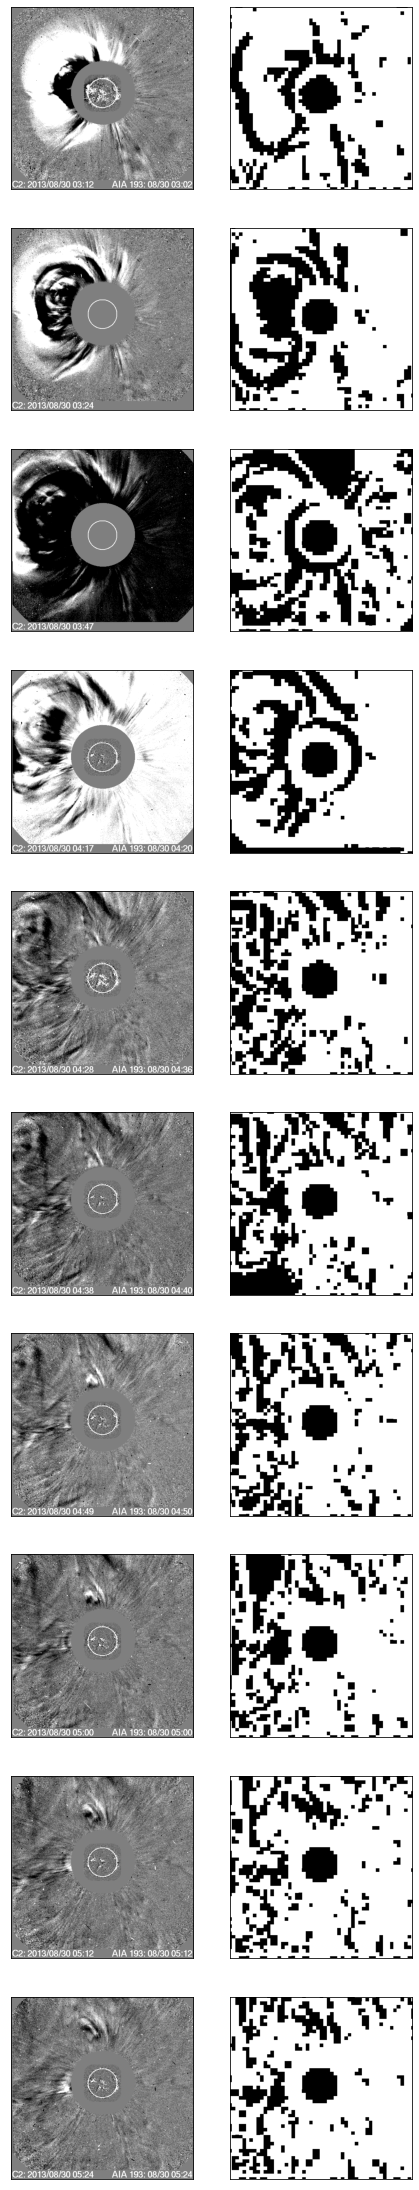

In [12]:
drawLargestComp(imgs, largestComps)
